## I&I

In [111]:
import pandas as pd
import numpy as np
import glob
from collections import Counter
from datetime import datetime

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
% matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# TODO:
    # extract features
    # convert to libsvm

## Read Data

### read .log

In [155]:
ls

2404data/          Acc_Test_240418.xlsx      mainRoadTrackNotebook.ipynb
Acc_Test1704.xlsx  CarExp_AccData_2202.xlsx  README.md


In [161]:
pd.read_csv('2404data/bumpers.log',skip_blank_lines=True,skiprows=0,delimiter=' ')

ParserError: Error tokenizing data. C error: Expected 13 fields in line 328, saw 20


### Read Excel

In [3]:
cd data

/home/gidi/nbs/RoadTrackACC/data


In [4]:
f=glob.glob('*.xlsx')
#excel=pd.ExcelFile(f[0])
f

['Acc_Data_Toyota_2604.xlsx',
 'Acc_Test1704.xlsx',
 'CarExp_AccData_2202.xlsx',
 'Acc_Test_240418.xlsx']

In [53]:
# put all sheets here
# ['Acc_Data_Toyota_2604.xlsx',
#  'Acc_Test1704.xlsx',
#  'Acc_Test_240418.xlsx']
category_dict = {'REGULAR DRIVE':0,'Standingstill':1,'Driving':0,
                 'Drive':0,  'Drive_2':0, 'Bumper_Low':4,
                 'Bumper_High':4,   'Bumper_High_2':4,     'Bumpers':4,
                'ZigZag':2,   'ZigZag_2':2,  'Emergency_stop':4,
                'Dirty_Road':3, 'Dirty_Road_2':3, 'Small_Bumper':4
                 ,'Emergency_Stop':5   ,'Emergency_Stop_2':5   ,'Reg_Driving1':0
                ,'Bumper_Low_Speed':4 ,'Reg_Driving2':0 ,'Hard_Stop':5
                ,'Bumpers':4 ,'DirtyRoad':3 ,'ZigZag1':2
                ,'ZigZag2':2,'ZigZag3':2}

Acc_Data_Toyota_2604.xlsx
REGULAR DRIVE
Bumpers
ZigZag
Emergency_stop
Dirty_Road
Small_Bumper
Acc_Test1704.xlsx
Standingstill
Driving
Bumper_Low
Bumper_High


/home/gidi/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Bumper_High_2
Dirty_Road
Dirty_Road_2
Emergency_Stop
Emergency_Stop_2
ZigZag
ZigZag_2
Drive_2
Acc_Test_240418.xlsx
Reg_Driving1
Bumper_Low_Speed
Reg_Driving2
Hard_Stop
Bumpers
DirtyRoad
ZigZag1
ZigZag2
ZigZag3


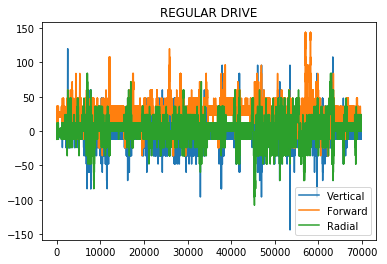

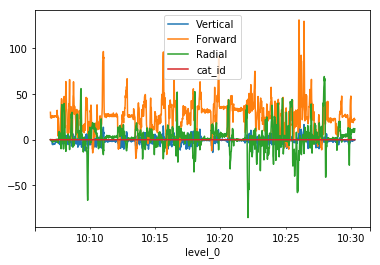

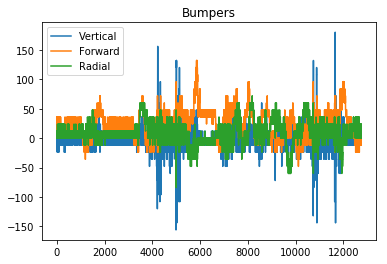

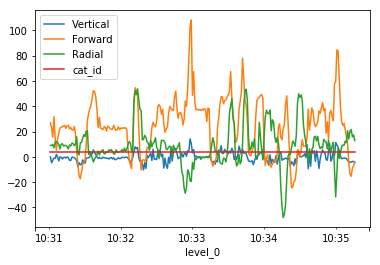

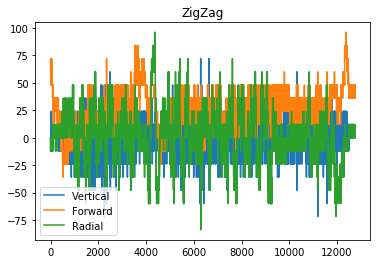

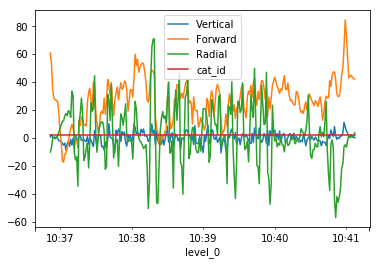

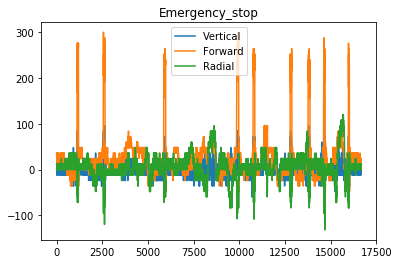

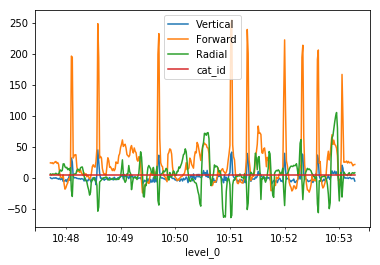

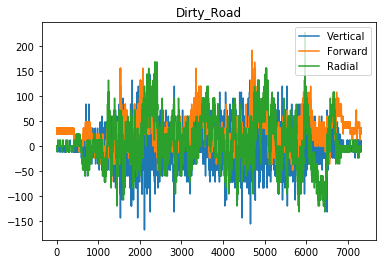

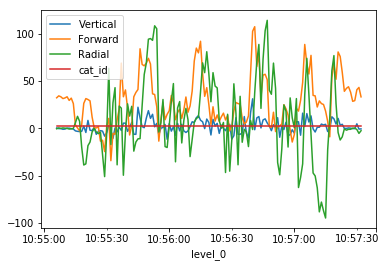

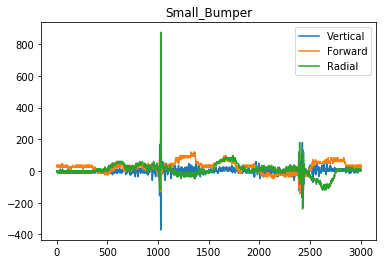

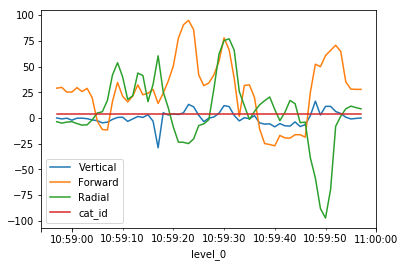

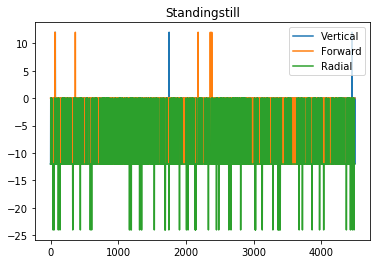

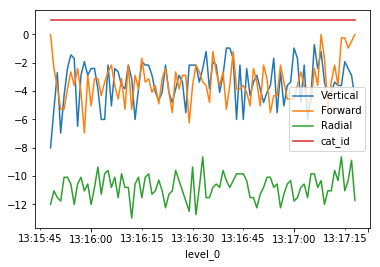

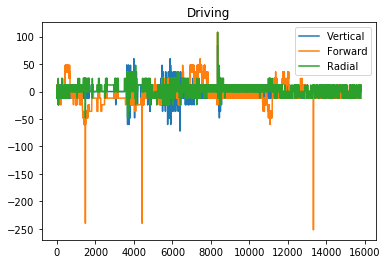

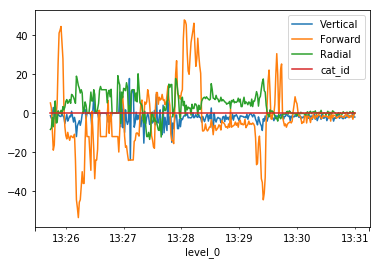

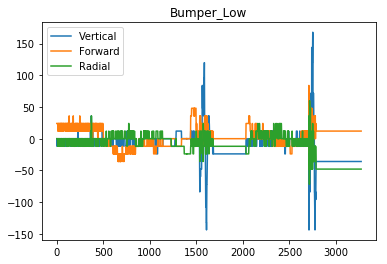

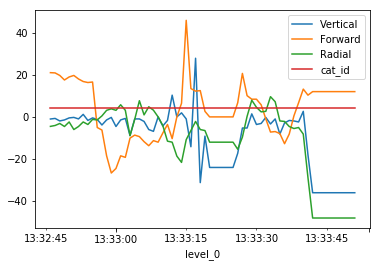

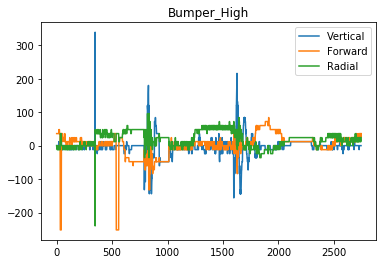

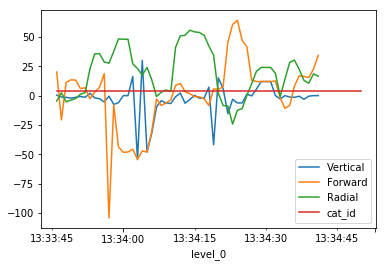

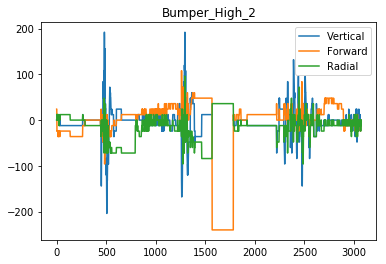

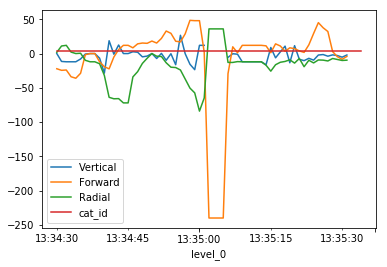

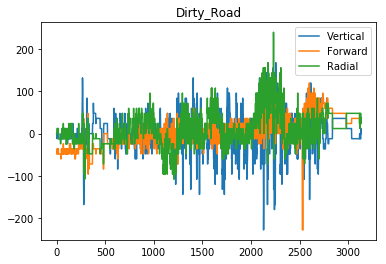

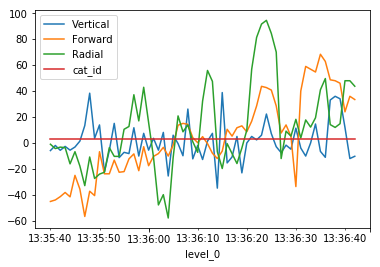

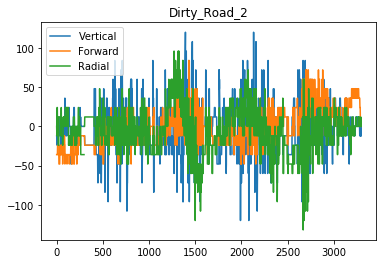

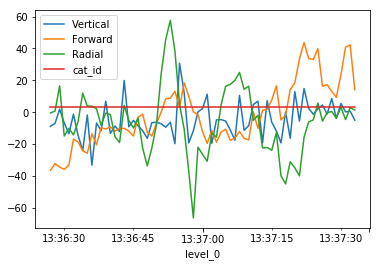

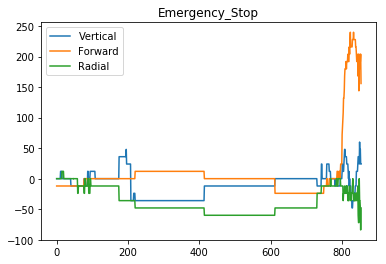

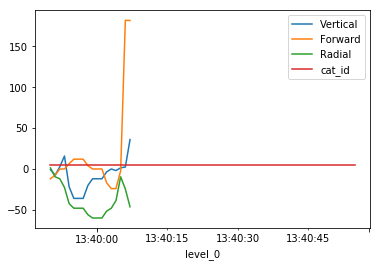

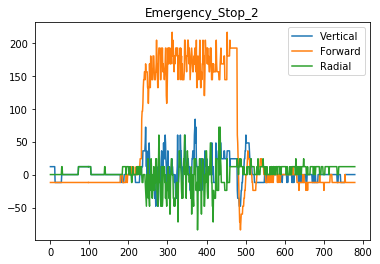

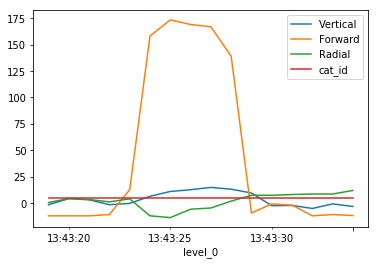

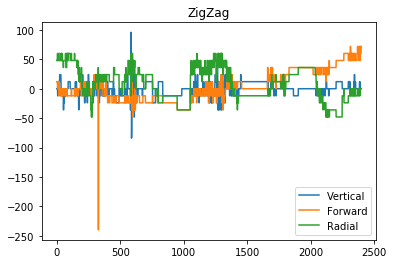

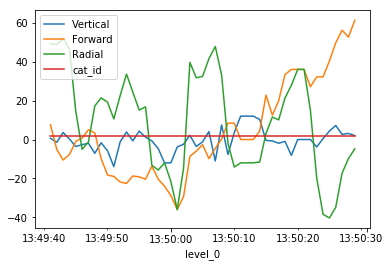

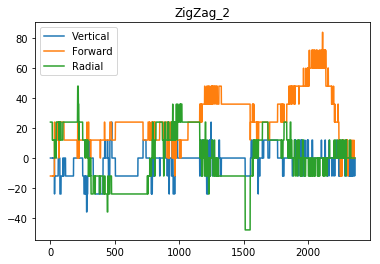

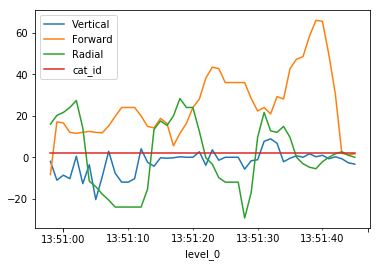

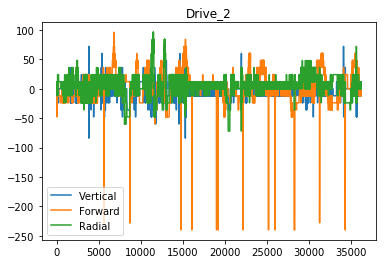

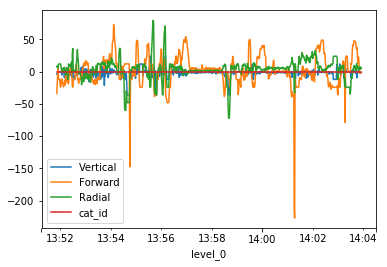

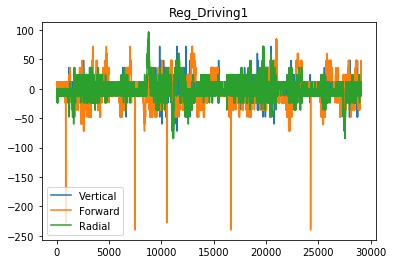

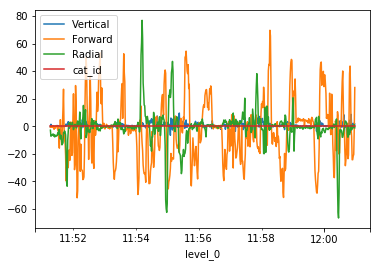

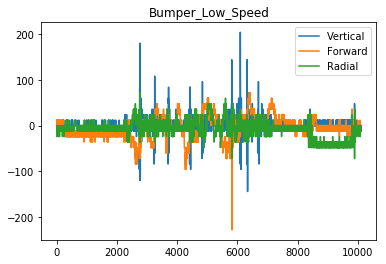

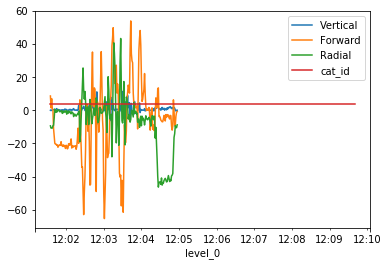

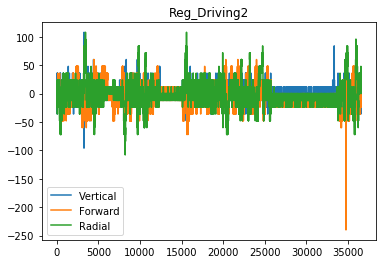

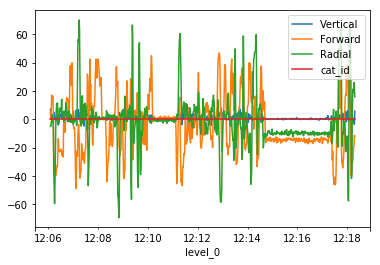

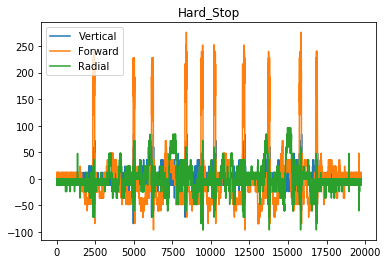

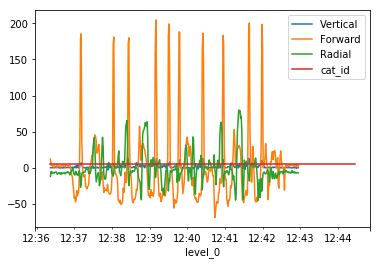

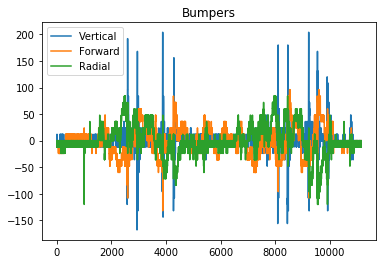

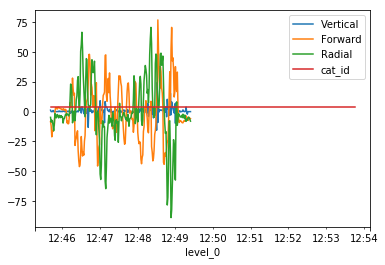

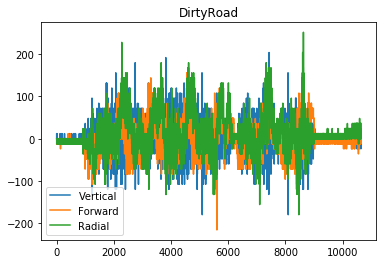

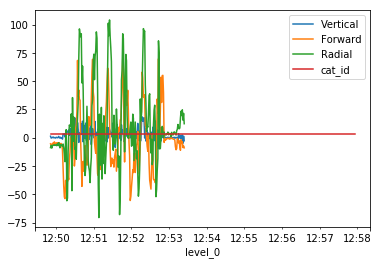

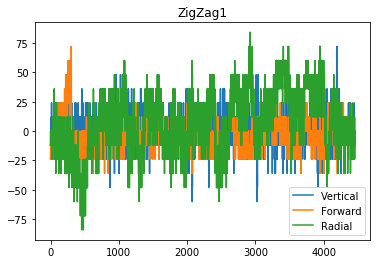

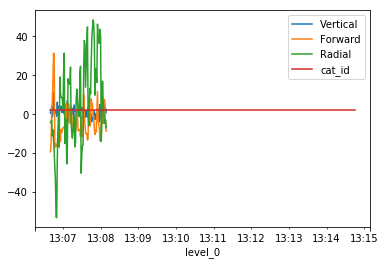

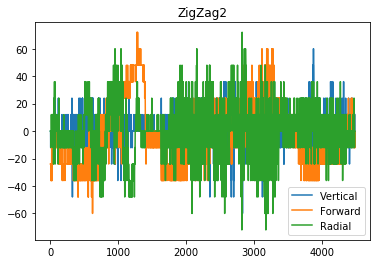

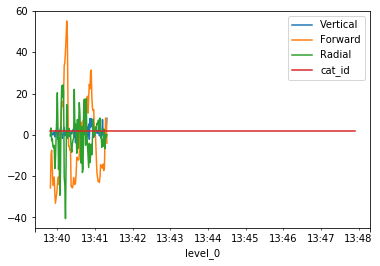

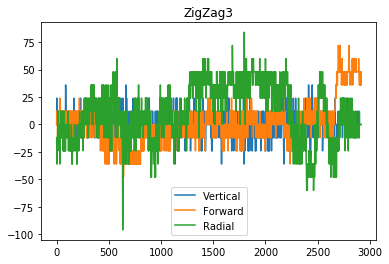

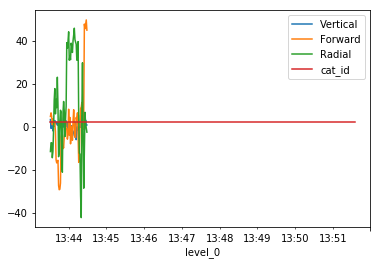

In [54]:
# excel 4
df_list=[]
for file_id in [0,1,-1]:
    print(f[file_id])

    excel=pd.ExcelFile(f[file_id])
    hz=50

    features=['Vertical','Forward','Radial','level_0']
    numeric_features=['Vertical','Forward','Radial']

    for i,name in enumerate(excel.sheet_names):
        df = excel.parse(name,header=1)
        df = df.reset_index()

        df.columns=[column.replace(' ','') for column in df.columns]

        df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors='coerce')
        df = df[features]
        df.Vertical = df.Vertical + 240
        #df['sum'] = df['Vertical']+df['Forward']+df['Radial']

        start = pd.Timestamp(df['level_0'][0].replace(']',''))
        end = start+ pd.Timedelta(milliseconds=1000/hz*len(df))
        t = np.linspace(start.value, end.value, len(df))
        t = pd.to_datetime(t)

        ax = df.plot(title=name)

        #df.index=df.index.to_datetime()
        df['level_0'] = t
        df = df.set_index(df['level_0'])
        df['cat'] = name
        df['cat_id'] = category_dict[name]
        print(name)
        
        if name in annotations:
            for anot in annotations[name]:
                df=df.iloc[anot[0]:anot[1]]
        df_list.append(df)
        df.resample('s').mean().plot() # resample by the second
     


Reg_Driving1
Bumper_Low_Speed
Reg_Driving2
Hard_Stop
Bumpers
DirtyRoad
ZigZag1
ZigZag2
ZigZag3


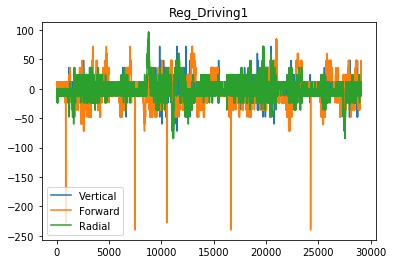

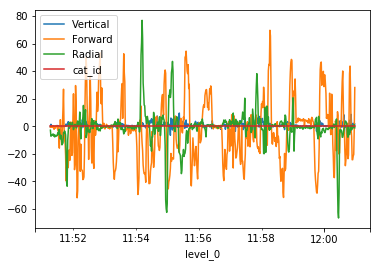

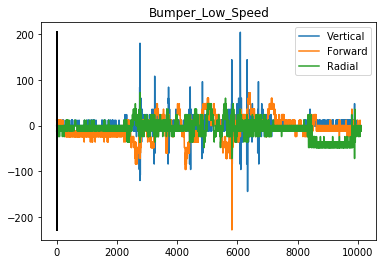

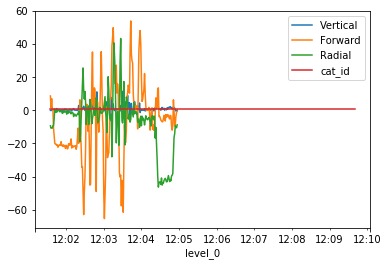

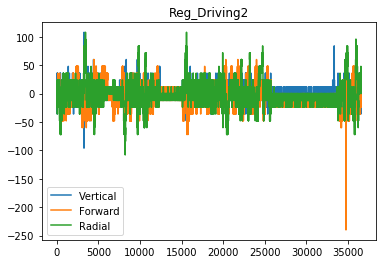

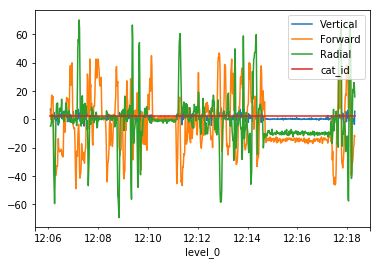

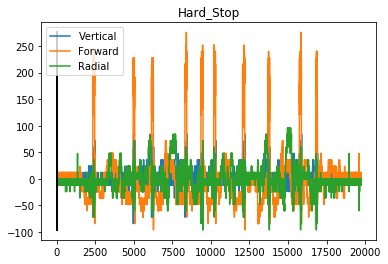

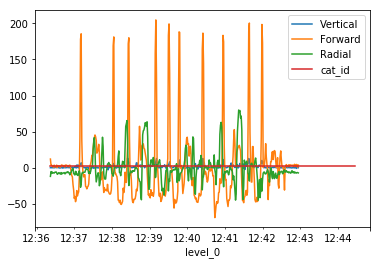

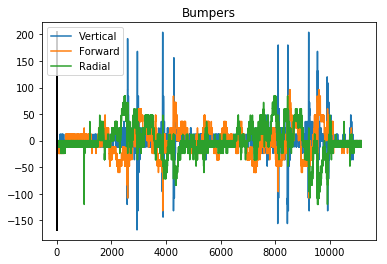

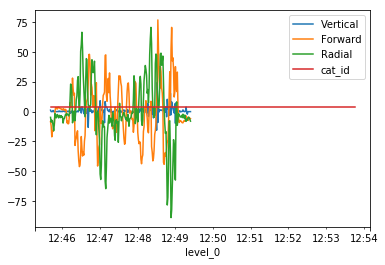

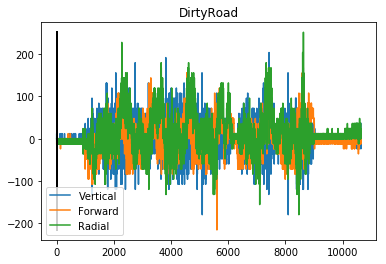

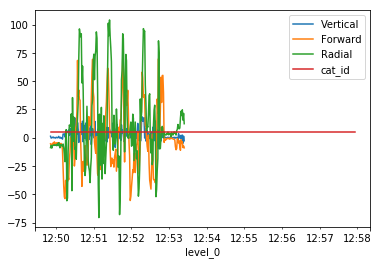

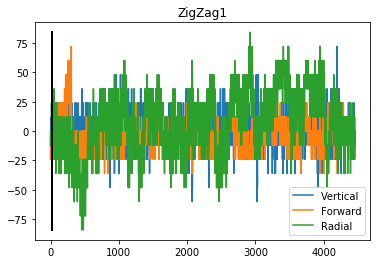

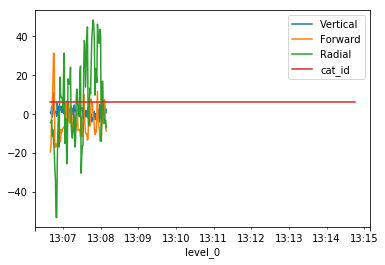

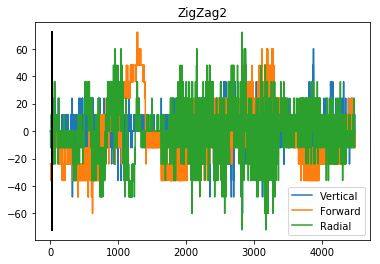

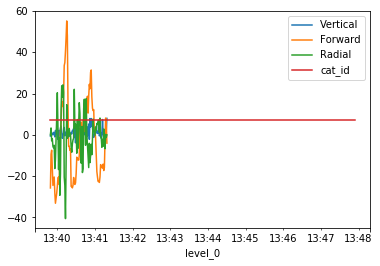

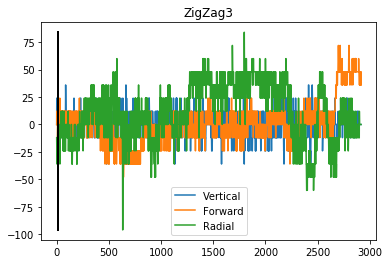

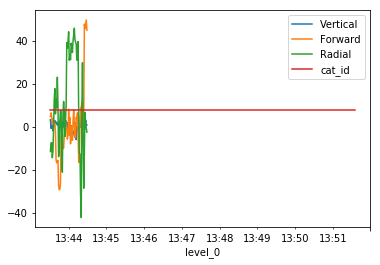

In [269]:
# second file 100 hz
# or third file 50 hz
hz=50

features=['Vertical','Forward','Radial','level_0']
numeric_features=['Vertical','Forward','Radial']
df_dict={}
categories = {}
for i,name in enumerate(excel.sheet_names):
    df = excel.parse(name,header=1)
    df = df.reset_index()

    #df = df.set_index('level_0')
    df.columns=[column.replace(' ','') for column in df.columns]
    start_end = np.where(df['Unnamed:6'].isin(['Start', 'End']))

    df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors='coerce')
    df=df[features]
    df.Vertical=df.Vertical+240
    #df['sum'] = df['Vertical']+df['Forward']+df['Radial']
    
    start = pd.Timestamp(df['level_0'][0].replace(']',''))
    end = start+ pd.Timedelta(milliseconds=1000/hz*len(df))
    t = np.linspace(start.value, end.value, len(df))
    t = pd.to_datetime(t)

    ax=df.plot(title=name)
    try:
        ax.plot([ start_end[0][0],start_end[0][0]], [min(df[features].min()),max(df[features].max())], 'k-', lw=2)
        ax.plot([ start_end[0][1],start_end[0][1]], [min(df[features].min()),max(df[features].max())], 'k-', lw=2)
    except:
        pass
    #df.index=df.index.to_datetime()
    df['level_0']=t
    df = df.set_index(df['level_0'])
    print(name)
    df_dict[name]=df
    df_dict[name]['cat'] = name # add category
    df_dict[name]['cat_id']=i
    df.resample('s').mean().plot() # resample by the second
    categories[name]=i
    #a=df.resample('1S')
    #a.plot()

In [55]:
# make 1 dataframe
research_df=pd.DataFrame()
for df in df_list:
    research_df=research_df.append(df)
    
research_df.level_0=research_df.index.round('s') 
research_df.head(2)

,Vertical,Forward,Radial,level_0,cat,cat_id
level_0,,,,,,
2018-04-27 10:07:00.964000000,0.0,24.0,0.0,2018-04-27 10:07:01,REGULAR DRIVE,0
2018-04-27 10:07:00.984000256,0.0,36.0,0.0,2018-04-27 10:07:01,REGULAR DRIVE,0


### parse data

In [56]:
# extract fetures
research_dfa=research_df.groupby('level_0')['Vertical','Radial','Forward'].mean()\
    .join(research_df.groupby('level_0')['Vertical','Radial','Forward'].std(), rsuffix='_std')\
    .join(research_df.groupby('level_0')['Vertical','Radial','Forward'].max(), rsuffix='_max')\
    .join(research_df.groupby('level_0')['Vertical','Radial','Forward'].min(), rsuffix='_min')\
    .join(research_df.groupby('level_0')['cat_id'].max())

/home/gidi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'level_0' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


In [57]:
Counter(research_dfa.cat_id)

Counter({0: 3540, 1: 91, 2: 1375, 3: 511, 4: 1792, 5: 569})

In [58]:
research_dfa=research_dfa[research_dfa.cat_id.isin([0,2,3])].fillna(0)
# leave only standard, dirty and zigzag

In [59]:
Counter(research_dfa.cat_id)

Counter({0: 3540, 2: 1375, 3: 511})

## Modeling

### basic

In [60]:
trn,test = train_test_split(research_dfa)
len(trn), len(test)

(4069, 1357)

In [63]:
features

['Vertical', 'Forward', 'Radial', 'level_0']

In [64]:
features=['Vertical_std','Forward_std','Radial_std',\
          'Vertical','Forward','Radial',\
         'Vertical_max','Forward_max','Radial_max',\
         'Vertical_min','Forward_min','Radial_min']#'sum_mean','sum_std'

In [65]:
for model in [LogisticRegression(),svm.SVC(decision_function_shape='ovo')]:
    # SVM is much slower
    model.fit(trn[features],trn['cat_id'])
    print(model.score(test[features],test[['cat_id']]))

0.7907148120854827
0.8076639646278556


In [27]:
model.fit(trn[features],trn['cat_id'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
model.score(test[features],test[['cat_id']])

0.7059690493736183

### Kfold

In [66]:
# proper KFold
kf = KFold(5,shuffle=True,random_state=0)

for samples_train, samples_test in kf.split(research_dfa):
    model=LogisticRegression()
    X_train,X_valid, y_train,y_valid = research_dfa[features].iloc[samples_train],\
        research_dfa[features].iloc[samples_test]\
        ,research_dfa.cat_id[samples_train],research_dfa.cat_id[samples_test]
    model.fit(X_train,y_train)
    print(model.score(X_valid,y_valid))

0.7799263351749539
0.7861751152073733
0.784331797235023
0.7889400921658987
0.7880184331797235


In [666]:
# estimate feature importence
print(np.std(np.array(research_dfa[features]), 0)*model.coef_)

[[-1.23927605e+00  1.20106362e+00 -7.20456785e-01  5.66487127e-01
   8.85471174e-01  6.13340170e-01 -7.89467932e-02 -8.66736129e-01
  -2.31783825e-01  2.76452319e-02  4.88739040e-01 -3.52370438e-01]
 [ 1.49513333e+01  3.27832208e+00 -1.33581482e+00 -2.13510581e+01
  -1.17711643e+01  4.49457394e+00  3.30553821e+00  6.76923430e+00
  -4.86802978e+00  6.77405784e+00  3.78115183e+00  2.62179357e-01]
 [ 5.91626629e-01 -1.73146257e+00  1.04889120e+00 -2.74462553e-01
  -1.01869088e+00 -1.11265858e+00 -4.88476679e-02  1.34145296e+00
   6.70373516e-01  2.46453573e-01 -7.91291557e-01  4.32308194e-01]
 [ 1.29826456e+00 -5.25580998e-03  9.90827408e-01  5.78557688e-03
   1.02075059e+00 -2.66779210e-01  4.83667062e-03 -1.02183721e+00
  -5.21237835e-02 -6.05170695e-02  1.54513415e-01  1.12459601e-01]]


In [419]:
model.coef_

array([[-0.2173245 ,  0.42969429, -0.05525676,  0.0571352 , -0.01934951,
        -0.02239879],
       [ 0.13497371, -0.11028994, -0.02416387,  0.00495248,  0.00912632,
         0.00756184],
       [ 0.02014108, -0.59859111,  0.23327665, -0.09111805,  0.00468379,
         0.01878628]])

In [266]:
# feature selection
    # 1 - variance. not very clever
    # 2 - STD *coef

### SVM

In [31]:

X = [[0], [1], [2], [3]]
Y = [0, 1, 2, 3]
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X, Y) 


dec = clf.decision_function([[1]])
dec.shape[1] # 4 classes: 4*3/2 = 6

clf.decision_function_shape = "ovr"
dec = clf.decision_function([[1]])
dec.shape[1] # 4 classes

4

### Forrest

### Kalman filter

In [69]:
df_list[2].Vertical

level_0
2018-04-27 10:31:01.921999872     0.0
2018-04-27 10:31:01.942001408     0.0
2018-04-27 10:31:01.962002944     0.0
2018-04-27 10:31:01.982004480     0.0
2018-04-27 10:31:02.002006272     0.0
2018-04-27 10:31:02.022007808     0.0
2018-04-27 10:31:02.042009344     0.0
2018-04-27 10:31:02.062010880     0.0
2018-04-27 10:31:02.082012416     0.0
2018-04-27 10:31:02.102013952     0.0
2018-04-27 10:31:02.122015488     0.0
2018-04-27 10:31:02.142017024   -12.0
2018-04-27 10:31:02.162018816     0.0
2018-04-27 10:31:02.182020352     0.0
2018-04-27 10:31:02.202021888     0.0
2018-04-27 10:31:02.222023424     0.0
2018-04-27 10:31:02.242024960     0.0
2018-04-27 10:31:02.262026496     NaN
2018-04-27 10:31:02.282028032     0.0
2018-04-27 10:31:02.302029568     0.0
2018-04-27 10:31:02.322031360   -12.0
2018-04-27 10:31:02.342032896   -12.0
2018-04-27 10:31:02.362034432   -12.0
2018-04-27 10:31:02.382035968     0.0
2018-04-27 10:31:02.402037504     0.0
2018-04-27 10:31:02.422039040   -12.0
2018

In [71]:
# intial parameters
n_iter = len(df_list[2])
sz = (n_iter,) # size of array
x = 0 # truth value (typo in example at top of p. 13 calls this z)
z = df_list[2].Vertical.fillna(0)#np.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

Q = 1e-5 # process variance

# allocate space for arrays
xhat = np.zeros(sz)      # a posteri estimate of x
P = np.zeros(sz)         # a posteri error estimate
xhatminus = np.zeros(sz) # a priori estimate of x
Pminus = np.zeros(sz)    # a priori error estimate
K = np.zeros(sz)         # gain or blending factor

R = 0.1**2 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

In [133]:
id=23
dim='Radial'

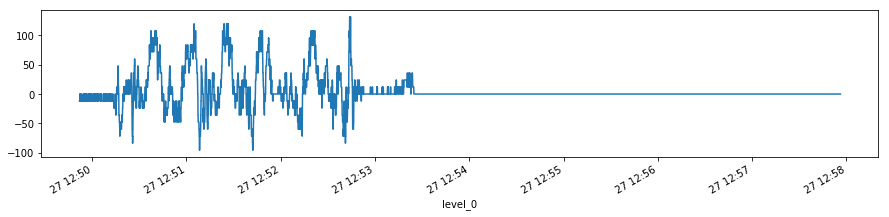

In [135]:
pd.rolling_median(df_list[id].fillna(0)[dim],15).plot(figsize=(15,3))

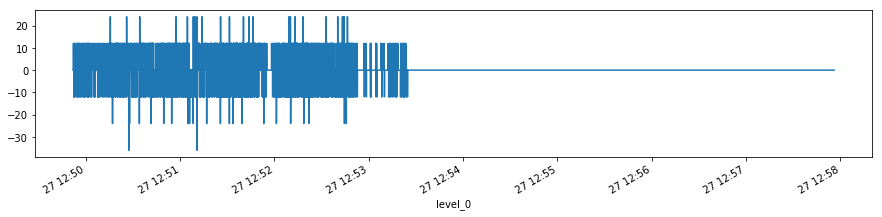

In [134]:
pd.rolling_median(df_list[id].fillna(0)[dim],15).diff(1).plot(figsize=(15,3))

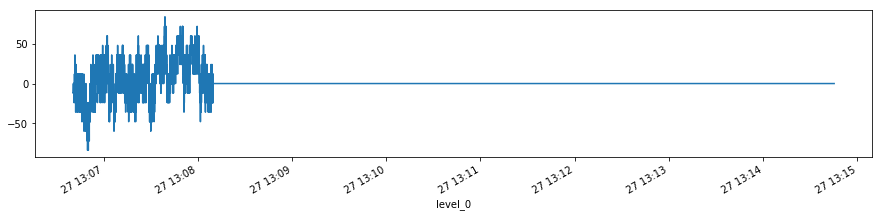

In [131]:
df_list[id].fillna(0)[dim].plot(figsize=(15,3))

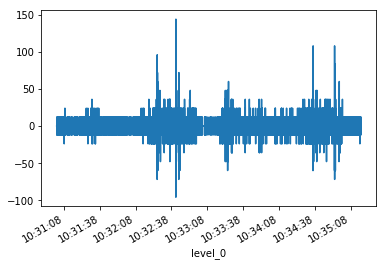

In [132]:
df_list[1].fillna(0).Vertical.diff(1).plot()

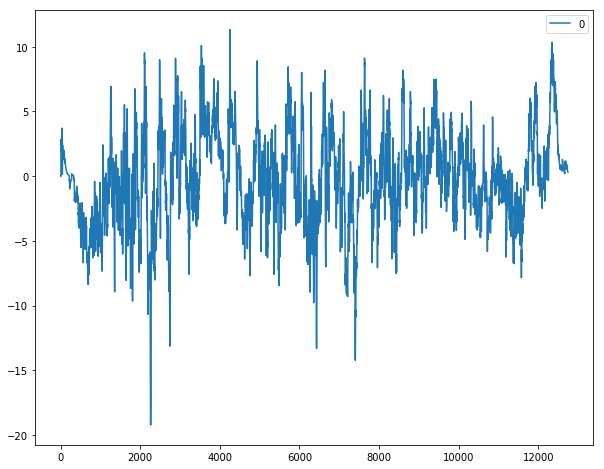

In [79]:
pd.DataFrame(xhat).plot()

In [74]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)
plt.figure()
plt.plot(z,'k+',label='noisy measurements')
plt.plot(xhat,'b-',label='a posteri estimate')
plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')


Text(0,0.5,'Voltage')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f677e7086a8> (for post_execute):


ValueError: ordinal must be >= 1

ValueError: ordinal must be >= 1

### prepare to convert

In [530]:
# train full model
model=LogisticRegression() #"best" model
model.fit(research_dfa[features],research_dfa['cat_id'])
model.coef_, model.intercept_

(array([[-0.2030422 ,  0.42991926, -0.08137797,  0.05350799, -0.01574018,
         -0.01518885],
        [ 0.11759804, -0.10445514, -0.00381828,  0.00856614,  0.00765495,
          0.00628376],
        [ 0.03010658, -0.61413439,  0.23996983, -0.0985568 ,  0.00259534,
          0.01255257]]), array([-1.25742184, -0.96226628,  0.24797999]))

In [309]:
research_dfa['cat_id'].unique()

array([0, 6])

In [ ]:
research_dfa[features]

In [480]:
stats={}
for cat in [0,5,6]:
    c=str(cat)
    stats['v_mean_'+c],stats['f_mean_'+c],stats['r_mean_'+c],_=round(research_df[research_df['cat_id']==cat].mean(),2)
    stats['v_std_'+c],stats['f_std_'+c],stats['r_std_'+c],_=round(research_df[research_df['cat_id']==cat].std(),2)

In [538]:
# read Hz samples 
# calc std, mean for each axis
# Hz simulator
data=[]
data_points=[]
preds=[]
pred_counter=0
period= np.random.randint(100,1000)
accuracy_list=[]
for i in range(10000):

    if counter > period: # every category change
        print('period', period,'cat', cat)
        period= np.random.randint(100,1000)
        rand_cat = np.random.randint(len([0,5,6]))
        cat=[0,5,6][rand_cat]
        counter=0
    if pred_counter > 50: # every second/ 50 hertz
        # do prediction
        pred_counter=10
        data_point = np.append(np.round(np.mean(data[-50:],axis=0),2),np.round((np.std(data[-50:],axis=0)),2))
        data_points.append(np.round(data_point,4))
        #print ('data point ', data_point)
        pred=model.predict([data_point])[0]
        print('prediciton is:',pred,'correct cat is',cat)
        accuracy_list.append(pred==cat)
        preds.append(pred)
    axes=[]
    for axis in ['v','f','r']:
        axes.append(np.random.normal(stats[axis+'_mean_'+str(cat)],stats[axis+'_std_'+str(cat)]))
    data.append(np.round(axes,2))
    
    counter+=1
    pred_counter+=1
    
pd.DataFrame(data_points).to_csv('simulated_data.csv')

prediciton is: 6 correct cat is 0
prediciton is: 6 correct cat is 0
prediciton is: 6 correct cat is 0
prediciton is: 6 correct cat is 0
period 609 cat 0
prediciton is: 6 correct cat is 5
prediciton is: 6 correct cat is 5
prediciton is: 6 correct cat is 5
prediciton is: 6 correct cat is 5
prediciton is: 6 correct cat is 5
prediciton is: 5 correct cat is 5
prediciton is: 6 correct cat is 5
prediciton is: 6 correct cat is 5
prediciton is: 6 correct cat is 5
prediciton is: 6 correct cat is 5
prediciton is: 0 correct cat is 5
prediciton is: 5 correct cat is 5
prediciton is: 6 correct cat is 5
prediciton is: 6 correct cat is 5
prediciton is: 6 correct cat is 5
prediciton is: 6 correct cat is 5
period 633 cat 5
prediciton is: 6 correct cat is 6
prediciton is: 6 correct cat is 6
prediciton is: 6 correct cat is 6
prediciton is: 6 correct cat is 6
prediciton is: 6 correct cat is 6
prediciton is: 6 correct cat is 6
prediciton is: 6 correct cat is 6
prediciton is: 6 correct cat is 6
prediciton is:

In [537]:
sum(accuracy_list)/len(accuracy_list),Counter(preds)

(0.23868312757201646, Counter({0: 12, 5: 20, 6: 211}))

In [540]:
pd.DataFrame(data_points)

,0,1,2,3,4,5
0,0.22,-6.59,-1.99,8.93,20.83,13.87
1,2.57,-4.38,-3.91,7.50,21.41,12.26
2,-0.09,-2.71,-4.00,7.45,25.38,13.91
3,-0.69,-4.96,-5.65,6.94,24.20,16.75
4,-1.52,-1.93,1.54,19.41,32.39,31.60
5,-2.82,0.81,19.77,35.31,29.89,44.13
6,0.42,1.06,15.38,32.58,28.38,34.46
7,-4.23,-12.08,19.43,28.09,28.31,41.54
8,6.90,-7.35,17.82,29.12,29.32,41.14
9,16.17,5.26,10.88,28.77,31.19,36.89


In [509]:
model.predict_proba([data_point])

array([[0.05790135, 0.30568807, 0.63641058]])

In [466]:
model.coef_

array([[-0.2030422 ,  0.42991926, -0.08137797,  0.05350799, -0.01574018,
        -0.01518885],
       [ 0.11759804, -0.10445514, -0.00381828,  0.00856614,  0.00765495,
         0.00628376],
       [ 0.03010658, -0.61413439,  0.23996983, -0.0985568 ,  0.00259534,
         0.01255257]])

In [465]:
top_layer=sigmoid(model.intercept_+model.coef_.dot(data_point))
top_layer/sum(top_layer)

array([0.04124154, 0.32571992, 0.63303855])

In [447]:
np.append(np.mean(data[-50:],axis=0),(np.std(data[-50:],axis=0)))

array([ 7.69895843,  2.78060926,  8.41978576, 24.79684022, 30.59621332,
       37.90140044])

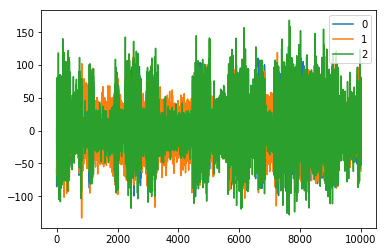

In [440]:
pd.DataFrame(data).plot()

## Lasso

In [ ]:

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn import datasets

In [111]:
diabetes = datasets.load_diabetes()
X = six_features[features]
y = six_features.cat_id_mean


In [108]:
X = np.c_[X, rng.randn(X.shape[0], 14)]  # add some bad features

# normalize data as done by Lars to allow for comparison
X /= np.sqrt(np.sum(X ** 2, axis=0))

In [112]:
np.concatenate(X, rng.randn(X.shape[0], 14))

TypeError: only integer scalar arrays can be converted to a scalar index

In [113]:
X.shape

(40, 6)

/home/gidi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10


Computing regularization path using the coordinate descent lasso...
Computing regularization path using the Lars lasso...


/home/gidi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log10


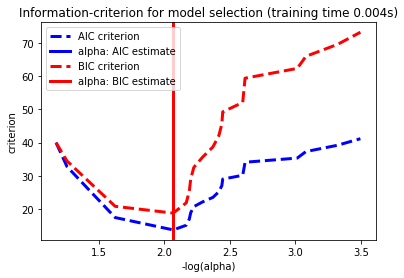

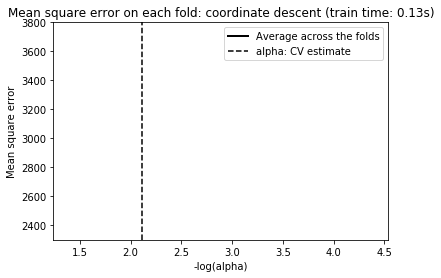

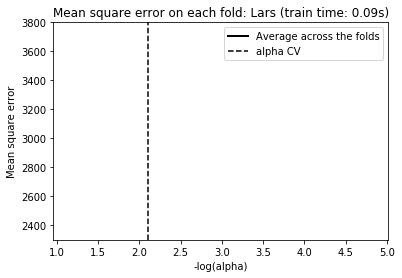

In [105]:
rng = np.random.RandomState(42)

# #############################################################################
# LassoLarsIC: least angle regression with BIC/AIC criterion

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)' % t_bic)

# #############################################################################
# LassoCV: coordinate descent

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=20).fit(X, y)
t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',label='alpha: CV estimate')

plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ' '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

# #############################################################################
# LassoLarsCV: least angle regression

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()
model = LassoLarsCV(cv=20).fit(X, y)
t_lasso_lars_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.cv_alphas_)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k', label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k', label='alpha CV')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars (train time: %.2fs)'
          % t_lasso_lars_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

plt.show()

## More

In [37]:
a=excel.parse(name)

In [39]:
a.reset_index()

,level_0,level_1,level_2,level_3,level_4,level_5,x,y,z,Unnamed: 3
0,Pushed device at line 5880,"DATA before push, line 2927 pushed the device",NaN,11:51:51.148,27,R,-240,0,0,NaN
1,NaN,NaN,NaN,11:51:51.148,58,R,-228,0,0,NaN
2,NaN,NaN,NaN,11:51:51.148,58,R,-228,-12,0,NaN
3,NaN,NaN,NaN,11:51:51.148,58,R,-228,-12,0,NaN
4,NaN,NaN,NaN,11:51:51.148,58,R,-228,-12,0,NaN
5,NaN,NaN,NaN,11:51:51.148,103,R,-216,-12,0,NaN
6,NaN,NaN,NaN,11:51:51.148,58,R,-228,-12,0,NaN
7,NaN,NaN,NaN,11:51:51.148,58,R,-228,-12,0,NaN
8,NaN,NaN,NaN,11:51:51.148,67,R,-228,-12,12,NaN
9,NaN,NaN,NaN,11:51:51.165,58,R,-228,0,0,NaN


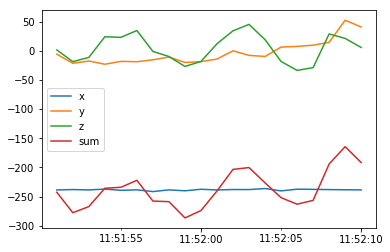

In [30]:
df.resample('s').mean().plot()

In [57]:
driver_door=excel.parse('Driver_Door')
driver_door=driver_door.reset_index()
driver_door=driver_door.set_index(driver_door.columns[3])
#driver_door.set_index(driver_door.columns[3])

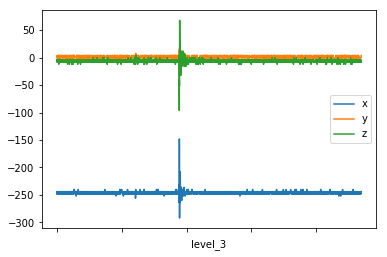

In [139]:

driver_door[['x','y','z']].apply(pd.to_numeric, errors='coerce').plot()

In [132]:
pd.to_numeric(driver_door[['z']],errors='coerce').plot()

TypeError: arg must be a list, tuple, 1-d array, or Series

In [73]:
driver_door.iloc[1646,:]

level_0        NaN
level_1        NaN
level_2        NaN
level_4         11
level_5          R
x             -248
y                0
z               -4
Unnamed: 3     NaN
Name: 11:16:58.010, dtype: object

## Altair plots

In [91]:
import altair as alt
from altair.expr import datum
from vega_datasets import data
%matplotlib inline

stocks = data.stocks()

chart = alt.Chart(driver_door[['x','y','z']]).mark_line(interpolate='step-after').encode(
    x = 'date',
    y = 'price'
).transform_filter(
    datum.symbol =='GOOG'
)

In [46]:
driver_door.columns

Index(['x', 'y', 'z', 'Unnamed: 3'], dtype='object')

In [87]:
cars = alt.load_dataset('cars')

In [106]:
driver_door.head()

,level_0,level_1,level_2,level_4,level_5,x,y,z,Unnamed: 3
level_3,,,,,,,,,
11:16:54.956,Pushed device at line 5880,"DATA before push, line 2927 pushed the device",NaN,14,R,-244,0,-4,NaN
11:16:54.956,NaN,NaN,NaN,8,R,-248,0,-8,NaN
11:16:54.956,NaN,NaN,NaN,8,R,-248,0,-8,NaN
11:16:54.956,NaN,NaN,NaN,8,R,-244,0,-8,NaN
11:16:54.956,NaN,NaN,NaN,8,R,-248,0,-8,NaN


In [131]:
driver_door[['x','y','z']].head()

,x,y,z
level_3,,,
11:16:54.956,-244,0,-4
11:16:54.956,-248,0,-8
11:16:54.956,-248,0,-8
11:16:54.956,-244,0,-8
11:16:54.956,-248,0,-8


In [129]:
driver_door[['x','y','z']].plot()

TypeError: Empty 'DataFrame': no numeric data to plot

In [127]:
chart.configure_scale(bandSize=60)

SchemaValidationError: Invalid specification

        altair.vegalite.v2.schema.core.ScaleConfig, validating 'additionalProperties'

        Additional properties are not allowed ('bandSize' was unexpected)
        

In [125]:
brush = alt.selection_interval()

alt.Chart(driver_door[['x','y','z']]).mark_line().encode(
    x='x',
    y='y',
).properties(
    selection=brush
)

<VegaLite 2 object>

In [99]:
import altair as alt

data = "https://frdata.wikimedia.org/donationdata-vs-day.csv"

chart = alt.Chart(data).mark_line().encode(
    alt.X(
        'date:T', timeUnit='monthdate',
        axis=alt.Axis(format='%B', title='Month')
    ),
    alt.Y(
        'max(ytdsum):Q', stack=None,
        axis=alt.Axis(title='Cumulative Donations')
    ),
    alt.Color('date:O', timeUnit='year', legend=alt.Legend(title='Year')),
    alt.Order('data:O', timeUnit='year')
)

## C++ LibLinear

In [468]:
cd ~/cloned_libs/liblinear/python

/home/gidi/cloned_libs/liblinear/python


In [469]:
from liblinearutil import *

In [470]:
# Read data in LIBSVM format
y, x = svm_read_problem('../heart_scale')
m = train(y[:200], x[:200], '-c 4')
p_label, p_acc, p_val = predict(y[200:], x[200:], m)

Accuracy = 81.4286% (57/70) (classification)


In [471]:
# Construct problem in python format
# Dense data
y, x = [1,-1], [[1,0,1], [-1,0,-1]]
# Sparse data
y, x = [1,-1], [{1:1, 3:1}, {1:-1,3:-1}]
prob  = problem(y, x)
param = parameter('-c 4 -B 1')
m = train(prob, param)
predict(y, x, m)

Accuracy = 100% (2/2) (classification)


([1.0, -1.0], (100.0, 0.0, 1.0), [[0.9695952896], [-0.9628844031999999]])

In [474]:
ls

heart_scale.model  liblinearutil.py  __pycache__/
liblinear.py       Makefile          README


In [472]:
# funcs
# gen_feature_nodearray, train, parameter, predict, svm_read_problem

In [14]:
# Other utility functions
save_model('heart_scale.model', m)
m = load_model('heart_scale.model')
#p_label, p_acc, p_val = predict(y, x, m, '-b 1')
#ACC, MSE, SCC = evaluations(y, p_label)

In [ ]:

# Other utility functions
save_model('heart_scale.model', m)
m = load_model('heart_scale.model')
p_label, p_acc, p_val = predict(y, x, m, '-b 1')
ACC, MSE, SCC = evaluations(y, p_label)

# Getting online help
help(train)

# The low-level use directly calls C interfaces imported by liblinear.py. Note that
# all arguments and return values are in ctypes format. You need to handle them
# carefully.

from liblinear import *
prob = problem([1,-1], [{1:1, 3:1}, {1:-1,3:-1}])
param = parameter('-c 4')
m = liblinear.train(prob, param) # m is a ctype pointer to a model
# Convert a Python-format instance to feature_nodearray, a ctypes structure
x0, max_idx = gen_feature_nodearray({1:1, 3:1})
label = liblinear.predict(m, x0)

## Peak Utils

In [ ]:

peaks=peakutils.indexes(research_dfa.reset_index().Vertical, thres=0.02/max(research_dfa.reset_index().Vertical), min_dist=100)

ax = research_dfa.reset_index().Vertical.fillna('').plot()

try:
    ax.plot([ 62,62], [-100,100], 'k-', lw=2)
    #ax.plot([ start_end[0][1],start_end[0][1]], [min(df[features].min()),max(df[features].max())], 'k-', lw=2)
except:
    pass